<a href="https://colab.research.google.com/github/FatemeSafariSarvandi/JFLAP-Project/blob/master/AutismImageDataset_VGG16_85%25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import gc
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten , Input
from tensorflow.keras import layers, models , Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.applications.mobilenet import preprocess_input
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fatemesafarisarvandi","key":"b092bdcd1b39095e68e6871d0520439f"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                           title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                       Student Performance Factors                          94KB  2024-09-02 10:53:57          34967        621  1.0              
valakhorasani/mobile-device-usage-and-user-behavior-dataset   Mobile Device Usage and User Behavior Dataset        11KB  2024-09-28 20:21:12           6900        124  1.0              
abdulszz/spotify-most-streamed-songs                          Spotify Most Streamed Songs                          60KB  2024-09-07 18:23:14          13930        179  1.0              
valakhorasani/gym-members-exercise-dataset                    Gym Memb

In [ ]:
! kaggle datasets download -d cihan063/autism-image-data

Dataset URL: https://www.kaggle.com/datasets/cihan063/autism-image-data
License(s): unknown
 88% 201M/229M [00:02<00:00, 117MB/s]
100% 229M/229M [00:02<00:00, 112MB/s]


In [ ]:
!unzip autism-image-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: AutismDataset/consolidated/Autistic/0881.jpg  
  inflating: AutismDataset/consolidated/Autistic/0882.jpg  
  inflating: AutismDataset/consolidated/Autistic/0883.jpg  
  inflating: AutismDataset/consolidated/Autistic/0884.jpg  
  inflating: AutismDataset/consolidated/Autistic/0885.jpg  
  inflating: AutismDataset/consolidated/Autistic/0886.jpg  
  inflating: AutismDataset/consolidated/Autistic/0887.jpg  
  inflating: AutismDataset/consolidated/Autistic/0888.jpg  
  inflating: AutismDataset/consolidated/Autistic/0889.jpg  
  inflating: AutismDataset/consolidated/Autistic/0890.jpg  
  inflating: AutismDataset/consolidated/Autistic/0891.jpg  
  inflating: AutismDataset/consolidated/Autistic/0892.jpg  
  inflating: AutismDataset/consolidated/Autistic/0893.jpg  
  inflating: AutismDataset/consolidated/Autistic/0894.jpg  
  inflating: AutismDataset/consolidated/Autistic/0895.jpg  
  inflating: AutismDataset/consolidated/Autistic/

In [ ]:
!ls ./AutismDataset/

consolidated  test  train  valid


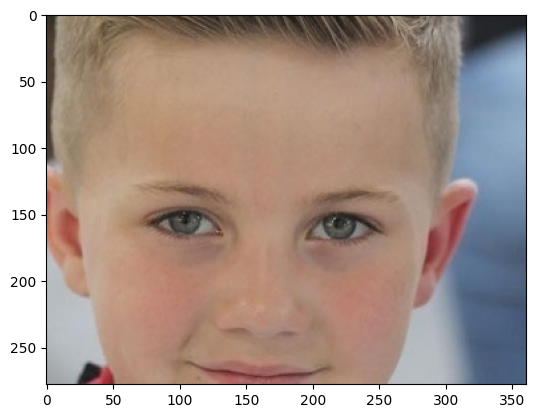

In [ ]:
img = cv2.imread('./AutismDataset/train/Non_Autistic.828.jpg',1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/Autistic
!mkdir data/train/Non_Autistic
!mkdir data/test/Autistic
!mkdir data/test/Non_Autistic

In [ ]:
!mv AutismDataset/train/Autistic*.jpg data/train/Autistic
!mv AutismDataset/train/Non_Autistic*.jpg data/train/Non_Autistic
!mv AutismDataset/test/Autistic*.jpg data/test/Autistic
!mv AutismDataset/test/Non_Autistic*.jpg data/test/Non_Autistic

In [ ]:
!ls

AutismDataset  autism-image-data.zip  data  kaggle.json  sample_data


In [ ]:
PATH1 = './AutismDataset/'
PATH2 = './data/'

In [ ]:
# Creating file path for our train data and test data
train_dir = os.path.join(PATH2, 'train')
test_dir = os.path.join(PATH2, 'test')
validation_dir = os.path.join(PATH1, 'valid')

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2540 files belonging to 2 classes.
Found 300 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [ ]:
# Prefetch data for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Apply data augmentation only to training data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

In [ ]:
# Calling pre-trained VGG16 model
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))

In [ ]:
# Base model (VGG16)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True


for layer in base_model.layers[:14]:
    layer.trainable = False

In [ ]:
# Define model architecture
model = tf.keras.Sequential([

    # Base model
    base_model,

    # Classification head
    layers.Flatten(),
    layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
# Early stopping callback to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Apply data augmentation only to the training dataset
augmented_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
# Train the model
history = model.fit(
    augmented_train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 49s 542ms/step - accuracy: 0.4944 - loss: 1.5966 - val_accuracy: 0.6200 - val_loss: 0.7241
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 76s 498ms/step - accuracy: 0.5623 - loss: 0.7260 - val_accuracy: 0.7500 - val_loss: 0.5643
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 499ms/step - accuracy: 0.6358 - loss: 0.6859 - val_accuracy: 0.7600 - val_loss: 0.5464
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 511ms/step - accuracy: 0.6757 - loss: 0.6418 - val_accuracy: 0.7900 - val_loss: 0.5803
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 81s 500ms/step - accuracy: 0.7050 - loss: 0.6120 - val_accuracy: 0.7500 - val_loss: 0.5644
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 508ms/step - accuracy: 0.6907 - loss: 0.6028 - val_accuracy: 0.7500 - val_loss: 0.5278
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 510ms/step - accuracy: 0.7086 - loss: 0.5973 - val_accuracy: 0.7500 - val_loss: 0.6290
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 511ms/step - accuracy: 0.7309 - loss: 0.5663 - 

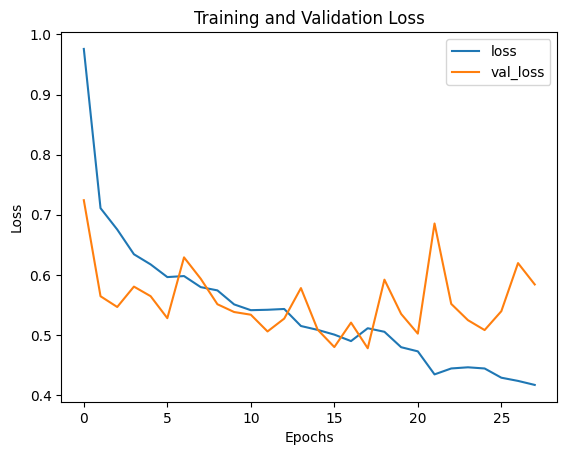

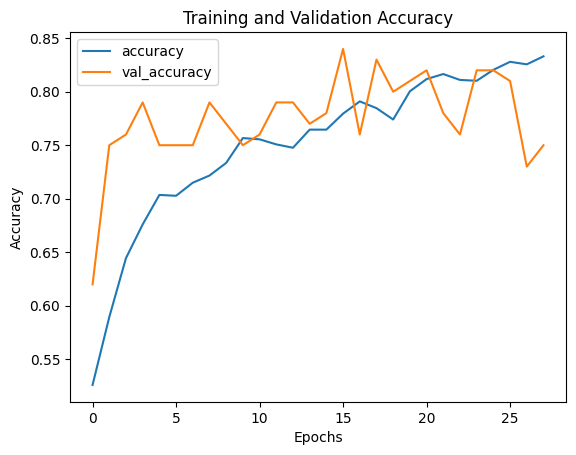

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
#evaluate test dataset
evalu = model.evaluate(test_dataset)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.8510 - loss: 0.3869




---

**mobilenet Model**

In [ ]:
# Base model (mobilenet)
base_model_mobilenet = tf.keras.applications.MobileNetV2(include_top=False,
                                                         weights='imagenet',
                                                         input_shape=(224, 224, 3))
base_model_mobilenet.trainable = True

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print("Number of layers in the base model: ", len(base_model_mobilenet.layers))

Number of layers in the base model:  154


In [ ]:
for layer in base_model_mobilenet.layers[:145]:
    layer.trainable = False

In [ ]:
# Define model architecture
model_mobilenet = tf.keras.Sequential([

    # Base model
    base_model_mobilenet,

    # Classification head
    # Global Average Pooling
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.015)),
    layers.Dropout(0.4),
    layers.Dense(2, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model_mobilenet.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
# Train the model
history_mobilenet = model_mobilenet.fit(
    augmented_train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 54s 537ms/step - accuracy: 0.6024 - loss: 3.9362 - val_accuracy: 0.7400 - val_loss: 3.2976
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 34s 418ms/step - accuracy: 0.6879 - loss: 3.1479 - val_accuracy: 0.6000 - val_loss: 2.6876
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 423ms/step - accuracy: 0.6913 - loss: 2.5526 - val_accuracy: 0.7400 - val_loss: 2.1841
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 436ms/step - accuracy: 0.7039 - loss: 2.0961 - val_accuracy: 0.7300 - val_loss: 1.8093
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 34s 421ms/step - accuracy: 0.7070 - loss: 1.7469 - val_accuracy: 0.7300 - val_loss: 1.5369
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 428ms/step - accuracy: 0.7162 - loss: 1.4749 - val_accuracy: 0.7100 - val_loss: 1.3192
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 34s 416ms/step - accuracy: 0.7124 - loss: 1.2755 - val_accuracy: 0.7400 - val_loss: 1.1461
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 445ms/step - accuracy: 0.7172 - loss: 1.1220 - val_accu

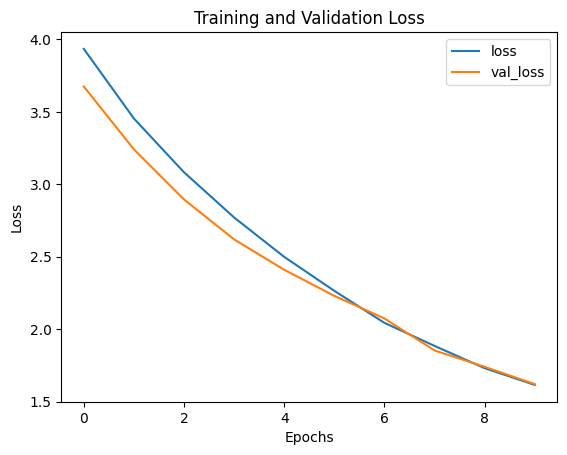

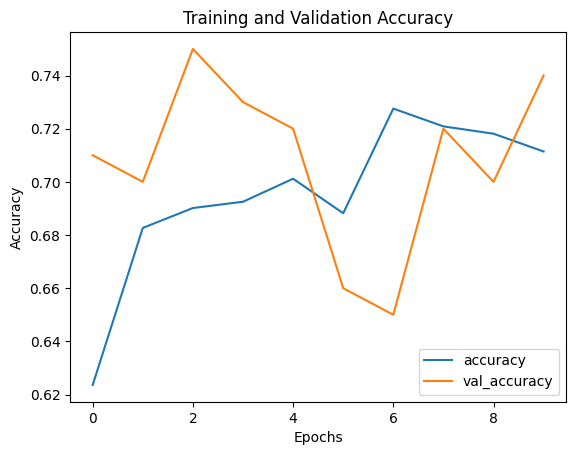

In [ ]:
history_frame_mobile = pd.DataFrame(history_mobilenet.history)
history_frame_mobile.loc[:, ['loss', 'val_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()
history_frame_mobile.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
#evaluate test dataset
evalu_mobile = model_mobilenet.evaluate(test_dataset)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7098 - loss: 3.2990
